In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install gym cma glfw mujoco
!pip install brax

In [ ]:
import brax
from brax import envs
import jax
import jax.numpy as jnp

env = brax.envs.half_cheetah.Halfcheetah()
#env = brax.envs.inverted_double_pendulum.InvertedDoublePendulum()
rng = jax.random.PRNGKey(0)

#env.reset(rng)

In [ ]:
import gym
import numpy as np
import torch
import brax
from brax import envs
import jax
import jax.numpy as jnp
from copy import deepcopy, copy

import warnings

# Suppress specific DeprecationWarnings related to jax.tree_map
warnings.filterwarnings("ignore", category=DeprecationWarning, message=".*jax.tree_map is deprecated.*")

class BraxToGymWrapper(gym.Env):
    metadata = {'render.modes': ['human']}

    def __init__(self, env_name="inverted_double_pendulum"):
        super(BraxToGymWrapper, self).__init__()
        #env = brax.envs.inverted_double_pendulum.InvertedDoublePendulum()
        env = brax.envs.half_cheetah.Halfcheetah()

        rng = jax.random.PRNGKey(0)
        s = env.reset(rng)
        self.env = env
        self.rng = jax.random.PRNGKey(0)
        self.state = s
        self.prev_state = None

        # Adjust dtype to numpy dtype for Gym compatibility
        self.action_space = gym.spaces.Box(low=-1.0, high=1.0, shape=(6,), dtype=np.float32)
        print(f'Action space: {self.action_space}')
        #self.observation_space = gym.spaces.Box(low=-float('inf'), high=float('inf'), shape=(6,), dtype=np.float32)
        self.observation_space = None

    def reset(self):
        self.rng, rng_input = jax.random.split(self.rng)
        self.state = self.env.reset(rng_input)
        obs = self.concat_state(self.state)

        if self.observation_space is None:
          # Determine the size of the observation
          observation_size = obs.shape[0]
          print(f'Setting observation size: {observation_size}')

          # Optionally, determine the range of each observation component
          # This step might require domain knowledge or further inspection of multiple observations
          self.observation_space = gym.spaces.Box(low=-float('inf'), high=float('inf'), shape=(observation_size,) , dtype=np.float32)


        return torch.from_numpy(np.array(obs, dtype=np.float32))

    def step(self, action):
        # Ensure action is a JAX array and has the correct shape and dtype
        action = jnp.array(action, dtype=jnp.float32)
        self.prev_state = self.state
        self.state = self.brax_step(self.state, action)
        obs = self.concat_state(self.state)
        # Convert JAX device arrays to NumPy arrays first
        reward = np.array(self.state.reward, dtype=np.float32)
        done = np.array(self.state.done, dtype=bool)
        # Then convert these NumPy arrays to PyTorch tensors
        return (torch.from_numpy(np.array(obs, dtype=np.float32).copy()), torch.from_numpy(reward), torch.from_numpy(done), {})

    def concat_state(self, state):
        q, qd = state.pipeline_state.q, state.pipeline_state.qd
        return jnp.concatenate((q, qd))

    def render(self, mode='human'):
        pass  # Add rendering logic if necessary

    def close(self):
        pass  # Add any necessary cleanup



    @staticmethod
    @jax.jit
    def get_jacobian(s, a):

      def qd_step(s, a):
        s_prime = benv.step(s, a)
        ps_prime = s_prime.pipeline_state
        q, qd = ps_prime.q, ps_prime.qd
        return jnp.concatenate((q, qd))

      jac_qd_step = jax.jacobian(qd_step, argnums=[0, 1])
      j_s, j_a = jac_qd_step(s, a)
      j_qd = jnp.concatenate((j_s.pipeline_state.q, j_s.pipeline_state.qd), axis=1)
      #j_a = jnp.expand_dims(j_a, axis=1)
      j = jnp.concatenate((j_qd, j_a), axis=1)
      return j

    @staticmethod
    @jax.jit
    def brax_step(s, a):
        s_prime = benv.step(s, a)
        return s_prime


# Initialize the environment
env = BraxToGymWrapper()
benv = env.env
# Test the environment with one step
obs = env.reset()
rng = jax.random.PRNGKey(0)

action = env.action_space.sample()
print(action)

s = copy(env.state)
new_obs, reward, done, info = env.step(action)
# print(new_obs.size())
print("Observation:", new_obs)
print("Reward:", reward)
print("Done:", done)
print("Info:", info)
print("Action:", action)

s = env.state
print('curr state')
#print(s)

#j = env.get_jacobian(s, action)
#print(j)

#new_state, new_obs_concat, jacobian = env.step_and_jacobian(s, action)
def rolloutBraxEnv(env, num_steps=100):
    states = []
    actions = []
    jacobians = []
    obs = env.reset()
    states.append(obs)

    for i in range(num_steps):
        print(i)
        action = env.action_space.sample()  # Random action; replace with a policy if needed

        new_obs, reward, done, _ = env.step(action)

        # Get Jacobian
        j = env.get_jacobian(env.prev_state, action)
        jacobians.append(j)
        print(np.shape(j))
        states.append(new_obs)
        actions.append(action)

        if done:
          print('reseting env')
          env.reset()

    return states, actions, jacobians

states, actions, jacobians = rolloutBraxEnv(env, num_steps=40)


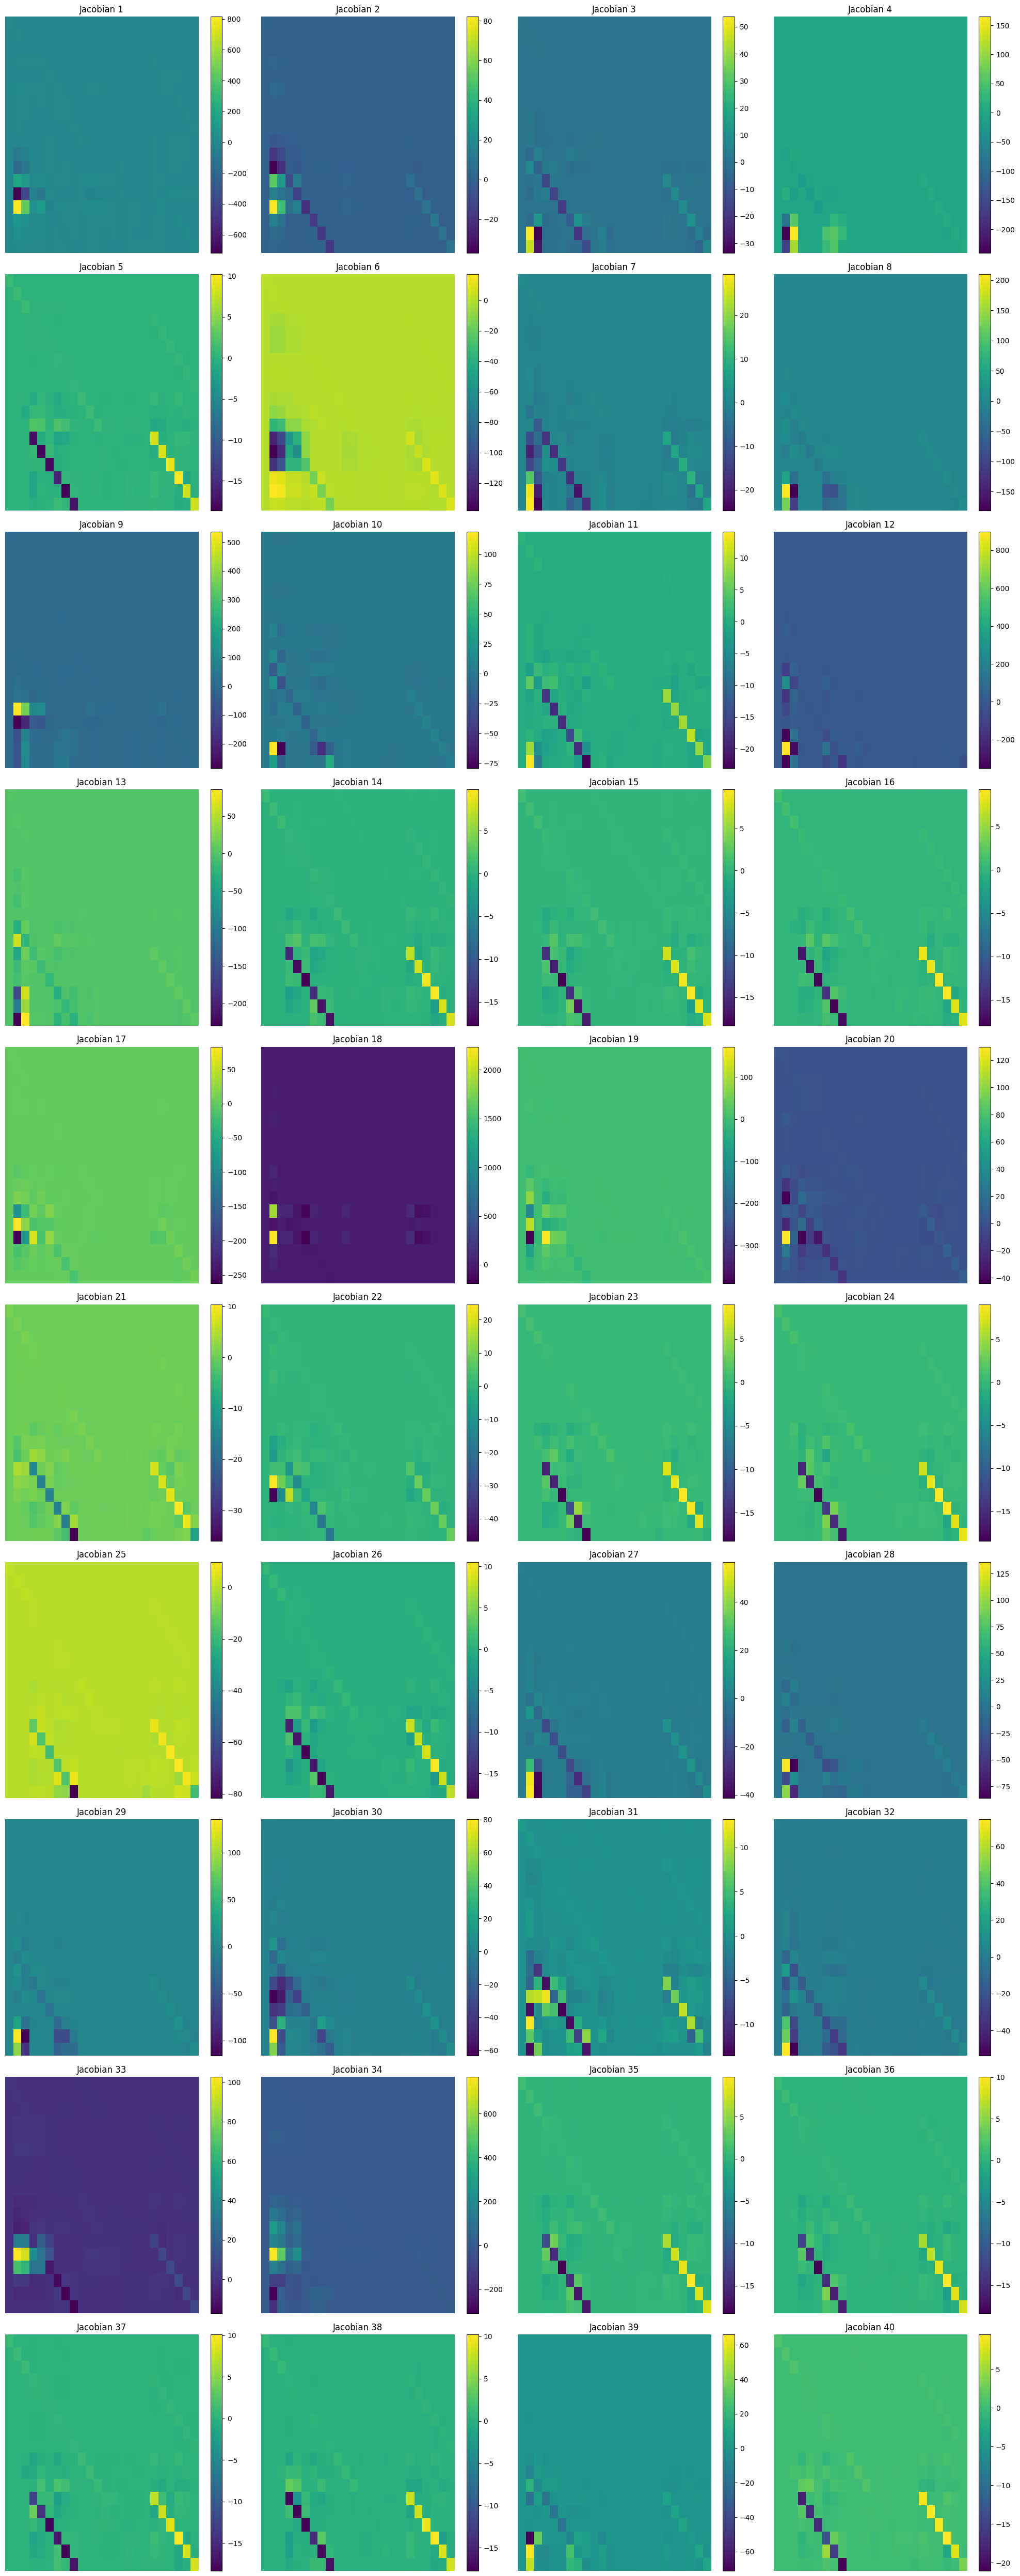

In [ ]:
import matplotlib.pyplot as plt

def plot_jacobians(jacobians):
    # Calculate the number of subplots needed
    num_jacobians = len(jacobians)
    cols = 4  # You can adjust this number based on your display preferences
    rows = (num_jacobians + cols - 1) // cols  # Calculate rows needed

    fig, axes = plt.subplots(rows, cols, figsize=(cols * 5, rows * 5))
    for i, ax in enumerate(axes.flatten()):
        if i < num_jacobians:
            im = ax.imshow(jacobians[i], aspect='auto', interpolation='none', cmap='viridis')
            ax.set_title(f'Jacobian {i + 1}')
            fig.colorbar(im, ax=ax)
        ax.axis('off')  # Turn off axis if no data
    plt.tight_layout()
    plt.show()
plot_jacobians(jacobians)

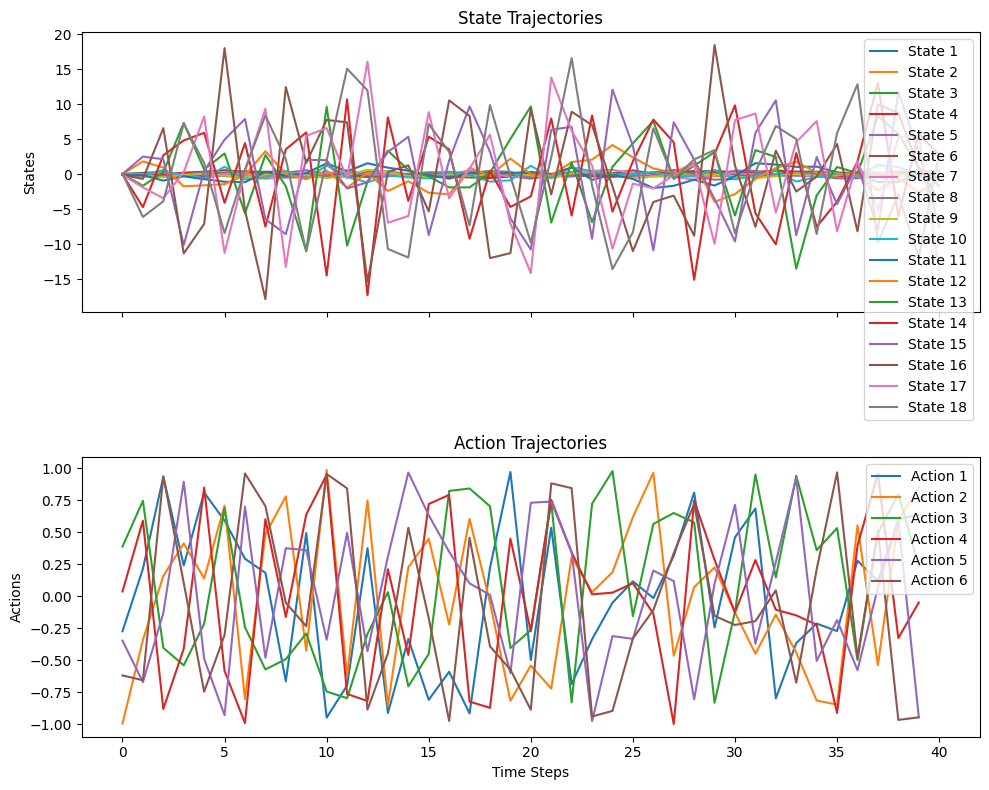

In [ ]:
def plot_state_actions(states, actions):
    states = np.array([s.numpy() for s in states])  # Convert tensors to numpy if they are not already
    actions = np.array(actions)

    fig, axs = plt.subplots(2, 1, figsize=(10, 8), sharex=True)

    # Plotting states
    axs[0].plot(states)
    axs[0].set_ylabel('States')
    axs[0].set_title('State Trajectories')
    axs[0].legend([f'State {i+1}' for i in range(states.shape[1])], loc='upper right')

    # Plotting actions
    axs[1].plot(actions)
    axs[1].set_ylabel('Actions')
    axs[1].set_title('Action Trajectories')
    axs[1].legend([f'Action {i+1}' for i in range(actions.shape[1])], loc='upper right')

    plt.xlabel('Time Steps')
    plt.tight_layout()
    plt.show()
plot_state_actions(states, actions)

#Define Model


##VAE

In [ ]:
import torch
from torch import nn

class VAE(nn.Module):
    def __init__(self, input_dim, latent_dim):
        super(VAE, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 2 * latent_dim)  # outputs mean and log variance
        )

        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, input_dim)
        )

    def reparameterize(self, mu, log_var):
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std)
        return mu + eps * std

    def encode(self, x):
        x = self.encoder(x)
        mu, log_var = x.chunk(2, dim=-1)
        z = self.reparameterize(mu, log_var)
        return z, mu, log_var

    def decode(self, z):
        return self.decoder(z)

    def forward(self, x):
        z, mu, log_var = self.encode(x)
        return self.decode(z), mu, log_var



##MDNRNN

In [ ]:

class MDNRNN(nn.Module):
    def __init__(self, z_dim=32, hidden_dim=256, n_gaussians=5, action_dim=6):
        super(MDNRNN, self).__init__()
        input_dim = z_dim + hidden_dim + action_dim  # Assuming `z_dim + hidden_dim + action_dim`
        self.rnn = nn.LSTM(input_dim, hidden_dim, batch_first=True)
        # Correcting the output dimension:
        output_dim = n_gaussians + 2 * n_gaussians * z_dim  # Mixtures + Means + Log Stds
        # self.fc = nn.Linear(hidden_dim, 3 * n_gaussians * z_dim)  # Use 3 * 5 = 15 for 5 mixtures
        self.fc = nn.Linear(hidden_dim, output_dim)
        self.n_gaussians = n_gaussians
        self.action_dim = action_dim
        self.z_dim = z_dim


    def forward(self, z, h):
        # inputs should be batched and contain [z, action, hidden_state]
        inputs = torch.cat([z, h], dim=-1)
        output, hidden = self.rnn(inputs)
        y = self.fc(output)
        return y, hidden

    def initial_state(self, batch_size):
        # Initial states for LSTM should be (h_0, c_0)
        return (torch.zeros(1, batch_size, 256), torch.zeros(1, batch_size, 256))  # Assuming one LSTM layer


##Controller

In [ ]:
class Controller(nn.Module):
    def __init__(self, z_dim=32, hidden_dim=256, action_dim=3):
        super(Controller, self).__init__()
        self.z_dim = z_dim
        self.hidden_dim = hidden_dim
        self.action_dim = action_dim
        self.linear = nn.Linear(z_dim + hidden_dim, action_dim)

    def forward(self, z, h):

        z = z.unsqueeze(0)
        inputs = torch.cat([z, h], dim=1)
        return self.linear(inputs)

class LargerController(nn.Module):
    def __init__(self, z_dim=32, hidden_dim=256, action_dim=3):
        super(Controller, self).__init__()
        self.z_dim = z_dim
        self.hidden_dim = hidden_dim
        self.action_dim = action_dim
        # Multi-layer perceptron
        self.network = nn.Sequential(
            nn.Linear(z_dim + hidden_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, action_dim)
        )

    def forward(self, z, h):
        z = z.unsqueeze(0)
        inputs = torch.cat([z, h], dim=1)
        return self.network(inputs)



#Train

In [ ]:
from torch.autograd.functional import jacobian
print(type(jacobian))

<class 'function'>


In [ ]:
import torch
import torch.nn.functional as F
from torch.autograd import grad
from torch.autograd.functional import jacobian


def differentiable_sampling_mixture(mdrnn, vae, input_state, action, hidden_state, temperature=1.0):
    z, _, _ = vae.encode(input_state)
    n_gaussians = mdrnn.n_gaussians
    z_dim = mdrnn.z_dim
    y, hidden = mdnrnn.forward(torch.cat([z.unsqueeze(0), action.unsqueeze(0)], dim=1),hidden_state)
    pi, mu, log_sigma = torch.split(y, [n_gaussians, n_gaussians*z_dim, n_gaussians*z_dim], dim=1)
    # Apply softmax to mixture coefficients with temperature
    logits = F.log_softmax(pi / temperature, dim=-1)
    print("l")
    print(logits.size())
    sigma = torch.exp(log_sigma)
    mu = mu.view(-1, n_gaussians, z_dim)
    sigma = sigma.view(-1,n_gaussians, z_dim)
    # Gumbel-Softmax sampling to get differentiable categorical draws
    gumbel_noise = -torch.log(-torch.log(torch.rand_like(logits)))
    y_soft = F.softmax((logits + gumbel_noise) / temperature, dim=-1)
    # Reparameterize to sample from the mixture model
    epsilon = torch.randn_like(mu)
    sampled_z = (mu + sigma * epsilon) * y_soft.unsqueeze(-1).sum(dim=0)
    print(sampled_z.size())

    sampled_z = torch.sum((mu + sigma * epsilon) * y_soft.unsqueeze(-1), dim=0)
    print(sampled_z.size())
    decoded_state = vae.decode(sampled_z)

    return decoded_state

    # k = differentiable_sampling_mixture(mdnrnn, vae, obs, action, hidden_state, temperature=1.0)
def sample_from_mdrnn(mdrnn, vae, input_state, action, hidden_state):
    z, _, _ = vae.encode(input_state)
    n_gaussians = mdrnn.n_gaussians
    z_dim = mdrnn.z_dim
    y, hidden = mdnrnn.forward(torch.cat([z.unsqueeze(0), action.unsqueeze(0)], dim=1),hidden_state)
    pi, mu, log_sigma = torch.split(y, [mdrnn.n_gaussians, mdrnn.n_gaussians * mdrnn.z_dim, mdrnn.n_gaussians * mdrnn.z_dim], dim=-1)
    pi = F.softmax(pi, dim=-1)
    mu = mu.view(-1, mdrnn.n_gaussians, mdrnn.z_dim)
    sigma = torch.exp(log_sigma.view(-1, mdrnn.n_gaussians, mdrnn.z_dim))

    # Sampling
    categorical = torch.distributions.Categorical(pi)
    gaussian_index = categorical.sample().item()
    normal = torch.distributions.Normal(mu[:, gaussian_index], sigma[:, gaussian_index])
    sample_z = normal.sample()

    decoded_state = vae.decode(sample_z)

    return decoded_state



def new_compute_neural_network_jacobian(mdrnn, vae, input_state, action, hidden_state, temperature=1.0, device='cuda'):
    """
    Computes the Jacobian of the output from the differentiable_sampling_mixture function with respect to its inputs.

    Args:
        mdrnn (torch.nn.Module): MDN-RNN model that outputs parameters of a Gaussian mixture.
        decoder (torch.nn.Module): Decoder model to transform latent states back to state space.
        input_state (torch.Tensor): The input state tensor, must require gradients.
        action (torch.Tensor): The action tensor, must require gradients.
        device (str): Device to perform computations on.

    Returns:
        torch.Tensor: The computed Jacobian matrix of the output with respect to [input_state, action].
    """

    # Ensure tensors are on the correct device and require gradients
    input_state = input_state.to(device).requires_grad_(True)
    action = action.to(device).requires_grad_(True)

    # Define the combined inputs tensor
    # combined_inputs = torch.cat([input_state, action], dim=1).requires_grad_(True)
    hidden_state = hidden_state.to(device).requires_grad_(True)

    # Define a function that passes combined inputs through the mixture model and decoder
    def n_forward_sample(input_state, action, hidden_state):
      z, _, _ = vae.encode(input_state)
      with torch.backends.cudnn.flags(enabled=False):
        y, hidden = mdrnn.forward(torch.cat([z.unsqueeze(0), action.unsqueeze(0)], dim=1), hidden_state)
      # y, hidden = mdrnn.forward(torch.cat([z.unsqueeze(0), action.unsqueeze(0)], dim=1), hidden_state)
      pi, mu, log_sigma = torch.split(y, [mdrnn.n_gaussians, mdrnn.n_gaussians * mdrnn.z_dim, mdrnn.n_gaussians * mdrnn.z_dim], dim=-1)
      pi = F.softmax(pi, dim=-1)
      mu = mu.view(-1, mdrnn.n_gaussians, mdrnn.z_dim)
      sigma = torch.exp(log_sigma.view(-1, mdrnn.n_gaussians, mdrnn.z_dim))

      # Select one component based on pi
      categorical = torch.distributions.Categorical(pi)
      index = categorical.sample()  # This samples an index based on pi probabilities
      selected_mu = mu[:, index, :]
      selected_sigma = sigma[:, index, :]

      # Reparameterization trick
      epsilon = torch.randn_like(selected_sigma)
      sample_z = selected_mu + selected_sigma * epsilon  # This is now [1, z_dim]

      decoded_state = vae.decode(sample_z.squeeze(0))
      return decoded_state

    # Compute the Jacobian of the outputs with respect to the combined inputs
    j = torch.autograd.functional.jacobian(n_forward_sample, (input_state, action, hidden_state), create_graph=True, vectorize=False)


    return j

def jacobian_alignment_loss(mdrnn, vae, s, a, hidden_state, true_jacobian):

    """
    Computes the Jacobian alignment loss between a model's predicted Jacobian and the differential environment's Jacobian.

    Args:
        model (torch.nn.Module): The model whose Jacobian will be aligned.
        mdrnn (torch.nn.Module): The MDN-RNN model used for sampling.
        decoder (torch.nn.Module): The decoder to transform latent states back to state space.
        s (torch.Tensor): The current state.
        a (torch.Tensor): The action taken.
        true_jacobian (Tensor): the true Jacobian.

    Returns:
        torch.Tensor: The MSE loss between the two Jacobians.
    """
    # Use the differentiable_sampling_mixture to sample and decode
    # decoded_state = differentiable_sampling_mixture(mdrnn, vae, s, a, hidden_state)


    # Compute the model's Jacobian using the decoded state
    model_jacobian = new_compute_neural_network_jacobian(mdrnn, vae, s, a, hidden_state )
    model_jac = torch.cat([model_jacobian[0], model_jacobian[1]], dim=2)

    # Calculate MSE loss between the model's Jacobian and the true Jacobian
    loss = F.mse_loss(model_jac.squeeze(0), true_jacobian)

    return loss

In [ ]:
import torch
import torch.optim as optim
import numpy as np
import gym
import cma
from torchvision import transforms
import csv
import torch
import torch.nn as nn
import torch.nn.functional as F
import pickle
import gym
import jax.numpy as jnp
# Check if GPU/CUDA is available and set the device accordingly
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

env = BraxToGymWrapper()
benv = env.env
# Test the environment with one step
obs = env.reset()
rng = jax.random.PRNGKey(0)

action = env.action_space.sample()


s = copy(env.state)
obs, reward, done, info = env.step(action)



# # Parameters
input_dim = 18  # Adjust this if the dimension of the observation space changes
latent_dim = 8

# # Model and optimizer
vae = VAE(input_dim, latent_dim).to(device)
# optimizer = Adam(model.parameters(), lr=1e-3)
# Initialize models and move them to the device
# vae = VAE(input_channels=1, feature_dim=17).to(device)
mdnrnn = MDNRNN(z_dim=8, hidden_dim=256, n_gaussians=5, action_dim=6).to(device)
# controller = Controller(z_dim=32, hidden_dim=256, action_dim=3).to(device)
controller = Controller(z_dim=8, hidden_dim=256, action_dim=6).to(device)
hidden_state = torch.zeros(1, 256).to(device)
action = torch.tensor(env.action_space.sample()).to(device)

obs = env.reset()
rng = jax.random.PRNGKey(0)
a = env.action_space.sample()
action = torch.tensor(a).to(device)


s = copy(env.state)
obs, reward, done, info = env.step(action)
obs = obs.to(device)

z, _ , _ = vae.encode(obs)
print(z.size())
j = env.get_jacobian(env.prev_state, a)
true_jacobian = torch.from_numpy(np.array(j)).to(device)


jacobian_alignment_loss(mdnrnn, vae, obs, action, hidden_state, true_jacobian)

Using device: cuda
Action space: Box(-1.0, 1.0, (6,), float32)
Setting observation size: 18
torch.Size([8])


tensor(4.9573, device='cuda:0', grad_fn=<MseLossBackward0>)

##Current

In [ ]:
env.action_space.sample()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


array([-0.942257  , -0.6495073 ,  0.16136247, -0.15692525,  0.9736005 ,
       -0.23457536], dtype=float32)

In [ ]:
import torch
import torch.optim as optim
import numpy as np
import gym
import cma
from torchvision import transforms
import csv
import torch
import torch.nn as nn
import torch.nn.functional as F
import pickle
import gym
import os
import random


base_dir = "/content/drive/MyDrive/WorldModel_New"
run_id = "run_{}".format(np.random.randint(10000))  # Example of generating a random run ID
run_dir = os.path.join(base_dir, run_id)

# Create the directory if it does not exist
os.makedirs(run_dir, exist_ok=True)
print(f"Data will be saved in directory: {run_dir}")

# Check if GPU/CUDA is available and set the device accordingly
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Assuming VAE, MDNRNN, and Controller classes have been defined as earlier
# Initialize the environment
# env = gym.make('CarRacing-v2')
# env = gym.make('HalfCheetah-v4')

# # Parameters
input_dim = 18  # Adjust this if the dimension of the observation space changes
latent_dim = 8

# # Model and optimizer
vae = VAE(input_dim, latent_dim).to(device)
# optimizer = Adam(model.parameters(), lr=1e-3)
# Initialize models and move them to the device
# vae = VAE(input_channels=1, feature_dim=17).to(device)
mdnrnn = MDNRNN(z_dim=8, hidden_dim=256, n_gaussians=5, action_dim=6).to(device)
# controller = Controller(z_dim=32, hidden_dim=256, action_dim=3).to(device)
controller = Controller(z_dim=8, hidden_dim=256, action_dim=6).to(device)



def mdnrnn_loss(output, target, n_gaussians=5, z_dim=8):
    # output is the result from the MDNRNN which contains mixture coefficients, means, and log standard deviations
    batch_size = target.size(0)

    pi, mu, log_sigma = torch.split(output, [n_gaussians, n_gaussians*z_dim, n_gaussians*z_dim], dim=1)

    # Softmax the mixture coefficients to ensure they sum to 1
    pi = F.softmax(pi, dim=1)
    # Exponentiate the log standard deviations to get the standard deviations
    sigma = torch.exp(log_sigma)

    # Reshape mu and sigma to align with the target for calculation
    mu = mu.view(batch_size, n_gaussians, z_dim)
    sigma = sigma.view(batch_size, n_gaussians, z_dim)

    # Target is duplicated across each mixture component for calculation
    target = target.unsqueeze(1).expand_as(mu)

    # Calculate the Gaussian probability densities
    exponent = -0.5 * ((target - mu) ** 2) / sigma ** 2
    norm_factor = torch.sqrt(2 * torch.pi * sigma ** 2)
    prob = torch.exp(exponent) / norm_factor

    # Sum over dimensions and multiply by the mixture coefficients
    prob = torch.sum(prob, dim=2)  # Sum over z_dim
    prob = pi * prob  # Apply mixing coefficients
    total_prob = torch.sum(prob, dim=1)  # Sum over n_gaussians

    # Calculate negative log likelihood
    nll = -torch.log(total_prob + 1e-8)  # Add a small number to avoid log(0)

    # Mean over batch
    return torch.mean(nll)

# Example usage inside your train function
# loss = mdnrnn_loss(outputs, next_z, n_gaussians=5, z_dim=32)


# Optimizers
vae_optimizer = optim.Adam(vae.parameters(), lr=0.001)
mdnrnn_optimizer = optim.Adam(mdnrnn.parameters(), lr=0.001)



def load_rollout_data(filename='/content/drive/MyDrive/WorldModel_New/rollout_data.pkl'):
    with open(filename, 'rb') as f:
        data = pickle.load(f)
    return data

# Function to save model weights
def save_model_weights(model, filename):
    file_path = os.path.join(run_dir, filename)
    torch.save(model.state_dict(), file_path)
    print(f"Model weights saved to {file_path}")

def load_model_weights(model, filename):
    file_path = os.path.join(run_dir, filename)
    if os.path.exists(file_path):
        model.load_state_dict(torch.load(file_path, map_location=device))
        print(f"Model weights loaded successfully from {file_path}")
    else:
        print(f"No model weights found at {file_path}. Check the file path and try again.")


def save_rollout_data(data, filename="rollout_data.pkl"):
    file_path = os.path.join(run_dir, filename)
    with open(file_path, 'wb') as f:
        pickle.dump(data, f)
    print(f"Data saved to {file_path}")

def collect_single_rollout(env, max_steps=100):
    obs = env.reset()
    done = False
    data = []
    cur_steps = 0
    while not done and cur_steps < max_steps:
      if cur_steps % 100 == 0:
        print(f'[rollout collecting] {cur_steps}')
      action = env.action_space.sample()
      next_obs, reward, done, info = env.step(action)
      j = env.get_jacobian(env.prev_state, actions)

      data.append((obs.numpy(), action, reward.numpy(), next_obs.numpy(), done.numpy(), j))
      obs = next_obs
      cur_steps += 1
    return data


def collect_multiple_rollouts(env, num_rollouts, max_steps=100):
    all_rollouts = []  # List to hold data from all rollouts
    for rollout_idx in range(num_rollouts):
        print(f'Starting rollout {rollout_idx + 1}/{num_rollouts}')
        obs = env.reset()
        done = False
        data = []
        cur_steps = 0
        while not done and cur_steps < max_steps:
            # if cur_steps % 10 == 0:  # Adjusted to print every 10 steps for better feedback
                # print(f'[rollout collecting] {cur_steps} steps')
            action = env.action_space.sample()
            next_obs, reward, done, info = env.step(action)
            j = env.get_jacobian(env.prev_state, action)
            all_rollouts.append((obs, action, reward, next_obs, done, np.array(j)))  # Store raw data without numpy conversion
            obs = next_obs
            cur_steps += 1

    return all_rollouts


def train_vae(data, epochs=5):
    vae.train()
    for epoch in range(epochs):
        total_loss = 0
        for obs, _, _, _, _, _ in data:
            obs = torch.tensor(obs).to(device).float()
            recon, mu, log_var = vae(obs)
            recon_loss = F.mse_loss(recon, obs)
            kl_div = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
            loss = recon_loss + kl_div
            vae_optimizer.zero_grad()
            loss.backward()
            vae_optimizer.step()
            total_loss += loss.item()
        print(f"Epoch {epoch}: Loss {total_loss / len(data)}")
        if epoch % 10 == 0 or epoch == epochs - 1:  # Save every 10 epochs and last epoch
            save_model_weights(vae, f"/content/drive/MyDrive/WorldModel_New/vae/vae_epoch_{epoch}.pth")

def train_mdn_rnn(data, epochs=10):
    mdnrnn.train()
    for epoch in range(epochs):
        total_loss = 0
        for obs, a, _, next_obs, _, jac in data:
            obs = torch.tensor(obs, requires_grad=True).to(device).float()
            next_obs = torch.tensor(next_obs).to(device).float()
            with torch.no_grad():
                z = vae.encode(obs)[0].unsqueeze(0)
                next_z = vae.encode(next_obs)[0].unsqueeze(0)
            action = torch.tensor(a, requires_grad=True).float().unsqueeze(0).to(device)
            # outputs, _ = mdnrnn(torch.cat([z, action], dim=1), torch.zeros(1, 256).to(device))
            # print(action.size())
            hidden_state = torch.zeros(1, 256, requires_grad = True).to(device)
            # action.requires_grad(True)
            # j = env.get_jacobian(env.prev_state, a)
            true_jacobian = torch.from_numpy(jac).to(device)
            loss = jacobian_alignment_loss(mdnrnn, vae, obs, action.squeeze(0),hidden_state , true_jacobian)
            # loss = mdnrnn_loss(outputs, next_z)
            mdnrnn_optimizer.zero_grad()
            # print("Loss grad_fn:", loss.grad_fn)
            # print("Observation grad_fn:", obs.grad_fn)
            loss.backward()
            mdnrnn_optimizer.step()
            total_loss += loss.item()
        print(f"Epoch {epoch}: MDN-RNN Loss {total_loss / len(data)}")
        if epoch % 10 == 0 or epoch == epochs - 1:  # Save every 10 epochs and last epoch
            save_model_weights(mdnrnn, f"/content/drive/MyDrive/WorldModel_New/rnn/mdnrnn_epoch_{epoch}.pth")

def train_mdn_rnn_regular(data, epochs=10):
    mdnrnn.train()
    for epoch in range(epochs):
        total_loss = 0
        for obs, a, _, next_obs, _, _ in data:
            obs = torch.tensor(obs, requires_grad=True).to(device).float()
            next_obs = torch.tensor(next_obs).to(device).float()
            with torch.no_grad():
                z = vae.encode(obs)[0].unsqueeze(0)
                next_z = vae.encode(next_obs)[0].unsqueeze(0)
            action = torch.tensor(a, requires_grad=True).float().unsqueeze(0).to(device)
            hidden_state = torch.zeros(1, 256, requires_grad = True).to(device)
            outputs, _ = mdnrnn(torch.cat([z, action], dim=1), hidden_state)
            loss = mdnrnn_loss(outputs, next_z)
            mdnrnn_optimizer.zero_grad()
            loss.backward()
            mdnrnn_optimizer.step()
            total_loss += loss.item()
        print(f"Epoch {epoch}: MDN-RNN Loss {total_loss / len(data)}")
        if epoch % 10 == 0 or epoch == epochs - 1:  # Save every 10 epochs and last epoch
            save_model_weights(mdnrnn, f"/content/drive/MyDrive/WorldModel_New/rnn/mdnrnn_epoch_{epoch}.pth")
import time
tmm = time.time()
print("Collecting data...")

data = collect_multiple_rollouts(env, 200, 400)

# data = load_rollout_data(filename='/content/drive/MyDrive/WorldModel_New/rollout_data.pkl')
# random.shuffle(data)
# data = data[:5000]
print(f'number of samples: {len(data)}')
save_rollout_data(data, filename="/content/drive/MyDrive/WorldModel_New/jacobian_rollout_data.pkl")
print("time to collect: " + str(time.time() - tmm))



# Train VAE
print("Training VAE...")
vae_time = time.time()
#train_vae(data)
# Path to the saved weights
vae_model_path = '/content/drive/MyDrive/WorldModel_New/vae/vae_epoch_19.pth'

# Load the model weights
if os.path.exists(vae_model_path):
    vae.load_state_dict(torch.load(vae_model_path, map_location=device))
    print("Model weights loaded successfully.")
else:
    print("Model path does not exist.")
    train_vae(data, 20)
print("time to collect: " + str(time.time() - vae_time))
print("Finished Training VAE...")



# Train MDN-RNN
print("Training MDN-RNN...")
rnn_time = time.time()
rnn_model_path = '/content/drive/MyDrive/WorldModel_New/rnn/mdnrnn_epoch_19.pth'

# Load the model weights
if os.path.exists(rnn_model_path):
    mdnrnn.load_state_dict(torch.load(rnn_model_path, map_location=device))
    print("Model weights loaded successfully.")
    train_mdn_rnn(data, 10)
else:
    print("Model path does not exist.")
    train_mdn_rnn(data, 10)
print("time to collect: " + str(time.time() - rnn_time))
print("Finished Training MDN-RNN...")




def rollout(controller, device='cuda'):
    controller.to(device)
    obs = env.reset()
    h = torch.zeros(1, 256, device=device).float()
    done = False
    cumulative_reward = 0
    cur_step = 0  # Initialize the counter
    while not done and cur_step < 500:
        if cur_step % 1 == 0:
            print(f'[rollout training] {cur_step}, cumulative_reward = {cumulative_reward}')
        with torch.no_grad():
            obs = torch.tensor(obs).to(device).float()
            z = vae.encode(obs)[0].to(device).float()
            # h = h.to(device).float()
            # print(h)
            action_tensor = controller(z, h)
            a = action_tensor.squeeze(0).cpu().numpy()
        obs, reward, done, _ = env.step(a)
        cumulative_reward += reward

        o, (h,c) = mdnrnn.forward(torch.cat([z.unsqueeze(0), action_tensor], dim=1),h)
        cur_step += 1
    return cumulative_reward

def evaluate_controller(parameters):
    # Assert the number of parameters is as expected
    expected_num_params = ((controller.z_dim + controller.hidden_dim) * controller.action_dim) + controller.action_dim
    assert len(parameters) == expected_num_params, f"Parameter size mismatch, expected {expected_num_params}, got {len(parameters)}"

    parameters_tensor = torch.tensor(parameters, dtype=torch.float32, device=device)

    # Calculate the number of weight parameters
    weight_params_count = (controller.z_dim + controller.hidden_dim) * controller.action_dim

    # Reshape the weight parameters
    controller.linear.weight.data = parameters_tensor[:weight_params_count].view(controller.action_dim, controller.z_dim + controller.hidden_dim)

    # Remaining parameters are for the bias
    controller.linear.bias.data = parameters_tensor[weight_params_count:weight_params_count + controller.action_dim]

    reward_tensor = rollout(controller)  # Assuming this returns a tensor

    # Ensure the reward is a scalar
    reward_scalar = reward_tensor.item()  # Convert tensor to scalar
    return reward_scalar

def evaluate_controller_2(parameters):
    # Flatten all parameters of the network for comparison
    param_shapes = [p.shape for p in controller.parameters()]
    total_params = sum(p.numel() for p in controller.parameters())
    assert len(parameters) == total_params, f"Parameter size mismatch, expected {total_params}, got {len(parameters)}"

    # Convert flat parameter list back to tensors with correct shapes
    parameters_tensor = torch.tensor(parameters, dtype=torch.float32, device=device)
    idx = 0
    with torch.no_grad():
        for p in controller.parameters():
            num_params = p.numel()
            p.data.copy_(parameters_tensor[idx:idx+num_params].view(p.shape))
            idx += num_params

    reward_tensor = rollout(controller)  # Assuming this returns a tensor

    # Ensure the reward is a scalar
    reward_scalar = reward_tensor.item()  # Convert tensor to scalar
    return reward_scalar



print("Evaluating controller...")
# Initialize the controller
# Calculate the total number of parameters needed
param_count = (controller.z_dim + controller.hidden_dim) * controller.action_dim + controller.action_dim
print(f"Calculated parameter count: {param_count}")

# Initialize parameters
params = np.random.randn(param_count)  # initial parameter guess
print(f"Initial parameters: {params}")

# Initialize CMA-ES with the initial parameters and a standard deviation of 0.5
es = cma.CMAEvolutionStrategy(params, 0.5)
print("CMA-ES initialized.")

# Run optimization
while not es.stop():
    print("CMA-ES iteration started.")

    # Ask for a new set of solutions
    solutions = es.ask()
    print(f"New solutions: {solutions}")

    # Evaluate fitness for each solution
    fitness = [evaluate_controller(s) for s in solutions]
    print(f"Fitness values: {fitness}")

    # Tell CMA-ES the fitness values
    es.tell(solutions, fitness)
    print("Fitness values provided to CMA-ES.")

    # Log progress
    es.logger.add()
    print("Progress logged.")

    # Print best fitness value so far
    print("Best fitness so far:", es.result.fbest)

# Load best parameters back into the controller
best_params = es.result.xbest
print(f"Best parameters found: {best_params}")

# Evaluate the controller with the best parameters
evaluate_controller(best_params)  # This sets the controller with the best parameters found
print("Controller evaluated with the best parameters.")
# Close the environment
env.close()


Data will be saved in directory: /content/drive/MyDrive/WorldModel_New/run_4094
Using device: cuda
Starting rollout 1/200
Starting rollout 2/200
Starting rollout 3/200
Starting rollout 4/200
Starting rollout 5/200
Starting rollout 6/200
Starting rollout 7/200
Starting rollout 8/200
Starting rollout 9/200
Starting rollout 10/200
Starting rollout 11/200
Starting rollout 12/200
Starting rollout 13/200
Starting rollout 14/200
Starting rollout 15/200
Starting rollout 16/200
Starting rollout 17/200
Starting rollout 18/200
Starting rollout 19/200
Starting rollout 20/200
Starting rollout 21/200
Starting rollout 22/200
Starting rollout 23/200
Starting rollout 24/200
Starting rollout 25/200
Starting rollout 26/200
Starting rollout 27/200
Starting rollout 28/200
Starting rollout 29/200
Starting rollout 30/200
Starting rollout 31/200
Starting rollout 32/200
Starting rollout 33/200
Starting rollout 34/200
Starting rollout 35/200
Starting rollout 36/200
Starting rollout 37/200
Starting rollout 38/20

In [ ]:
print(data[0])

(tensor([ 0.0737, -0.0511, -0.0502,  0.0920, -0.0183,  0.0082, -0.0341,  0.0417,
         0.0795, -0.1063,  0.1189,  0.1256, -0.0219, -0.1209,  0.0133,  0.2374,
         0.0661,  0.0438]), array([-0.3876123 , -0.7526086 ,  0.85490704, -0.51553744,  0.3314629 ,
       -0.531762  ], dtype=float32), tensor(-0.7235), tensor([ 0.0480, -0.0333,  0.0364, -0.0608, -0.2140,  0.3774, -0.2601,  0.1859,
        -0.1229, -0.6230,  0.3225,  2.3980, -3.6086, -5.1964,  8.1440, -5.6052,
         2.5995, -5.4716]), tensor(False))


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
evaluate_controller(es.result.xbest)

[rollout training] 0, cumulative_reward = 0


<ipython-input-17-51bf56c0e4a5>:294: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  obs = torch.tensor(obs).to(device).float()


[rollout training] 250, cumulative_reward = -3877.99951171875


-7436.69580078125

In [ ]:
from google.colab import files
files.download('/content/drive/MyDrive/WorldModel/vae_epoch_2.pth')  # Change filename accordingly
files.download("/content/drive/MyDrive/WorldModel/mdnrnn_epoch_20.pth")
files.download('/content/drive/MyDrive/WorldModel/rollout_data.csv')  # Change filename accordingly
